<a href="https://colab.research.google.com/github/KyleRoss-rice/tiny-cifar10-experiments/blob/main/scripts/datasaet_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Global setup

In [ ]:
dataset_dir = "datasets/CIFAR-10/Train" #@param {type:"string"}
n_subsets = 3 #@param {type:"slider", min:1, max:5, step:1}
n_samples_per_class = 10 #@param {type:"slider", min:1, max:20, step:1}
n_augmentations = 15 #@param {type:"slider", min:0, max:20, step:1}
images_export_filename = "mini-cifar10-aug.pt" #@param {type:"string"}
labels_export_filename = "mini-cifar10-aug-labels.pt" #@param {type:"string"}
is_download_subsets = True #@param {type:"boolean"}

In [ ]:
# import libraries
## pytorch
import torch
from torchvision import datasets, transforms

## data augmentation
!pip install imgaug -U -q
import imgaug
from imgaug import augmenters as iaa

## filesystem
import os
from google.colab import files

## plotting
import matplotlib.pyplot as plt

## serialization
import pickle

## basics
import numpy as np


     |████████████████████████████████| 952kB 5.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


### Data preprocessing pipes



In [ ]:
# augmentation
augmenter = iaa.SomeOf((1, None), [
                                   iaa.AverageBlur(k=(1,3)),
                                   iaa.Fliplr(1),
                                   iaa.Flipud(1),
                                   iaa.Affine(rotate=(-45, 45), mode='symmetric'),
                                   iaa.LinearContrast((0.4, 1.6), per_channel=True),
                                   iaa.Sharpen(alpha=(0.0, 0.5), lightness=(0.75, 1.25)),
                                   iaa.Affine(scale=(1, 1.5)),
                                   iaa.Cutout(fill_mode="gaussian", fill_per_channel=True),
                                   iaa.Dropout(p=(0, 0.01)),
                                   ])

# normalization
#normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  #std=[0.229, 0.224, 0.225])


### Download dataset

In [ ]:
# download dataset (if needed)
is_available = False
if os.path.isdir(dataset_dir):
  is_available = True
  print('Will not download dataset — Directory already exists')

cifar10_dataset = datasets.CIFAR10(root=dataset_dir, train=True, download=not is_available)


Extracting datasets/CIFAR-10/Train/cifar-10-python.tar.gz to datasets/CIFAR-10/Train


### Create subsets


In [ ]:
subset_indices = [None] * n_subsets

for i in range(n_subsets):
  random_permute = np.random.RandomState(i).permutation(np.arange(0, 5000))

  training_indices = np.concatenate(
      [np.where(np.array(cifar10_dataset.targets) == label)[0][random_permute[0:n_samples_per_class]] 
       for label in range(0, n_samples_per_class)])
  validation_indices = np.concatenate(
      [np.where(np.array(cifar10_dataset.targets) == label)[0][random_permute[n_samples_per_class:200+n_samples_per_class]]
       for label in range(0, 10)])  

  subset_indices[i] = (training_indices, validation_indices)

In [ ]:
# validate that no samples in the training subsets are in the validation subsets
for i in range(n_subsets):
  training_indices, validation_indices = subset_indices[i]
  assert(not np.isin(training_indices, validation_indices).any())

### Create augmented training subsets

In [ ]:
n_samples_per_subset = (n_augmentations + 1) * n_samples_per_class * 10
augmented_subsets = torch.empty((n_subsets, n_samples_per_subset, 3, 32, 32), 
                                 dtype=torch.int32)
labels = torch.empty((n_subsets, n_samples_per_subset), dtype=torch.int32)

for i in range(n_subsets):
  for j, image_idx in enumerate(subset_indices[i][0]):
    original_image = cifar10_dataset.data[image_idx]
    label = cifar10_dataset.targets[image_idx]
    labels[i,j * (n_augmentations + 1)] = label
    augmented_subsets[i,j * (n_augmentations + 1)] = torch.tensor(original_image).permute(2,0,1)
    for k in range(n_augmentations):
      new_image = augmenter(image=original_image)
      augmented_subsets[i,j * (n_augmentations + 1) + k + 1] = torch.tensor(new_image.copy()).permute(2,0,1)
      labels[i,j * (n_augmentations + 1) + k + 1] = label

In [ ]:
if is_download_subsets: 
  torch.save(augmented_subsets, images_export_filename)
  torch.save(labels, labels_export_filename)

  files.download(images_export_filename) 
  files.download(labels_export_filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Display the first 100 elements in the first subset

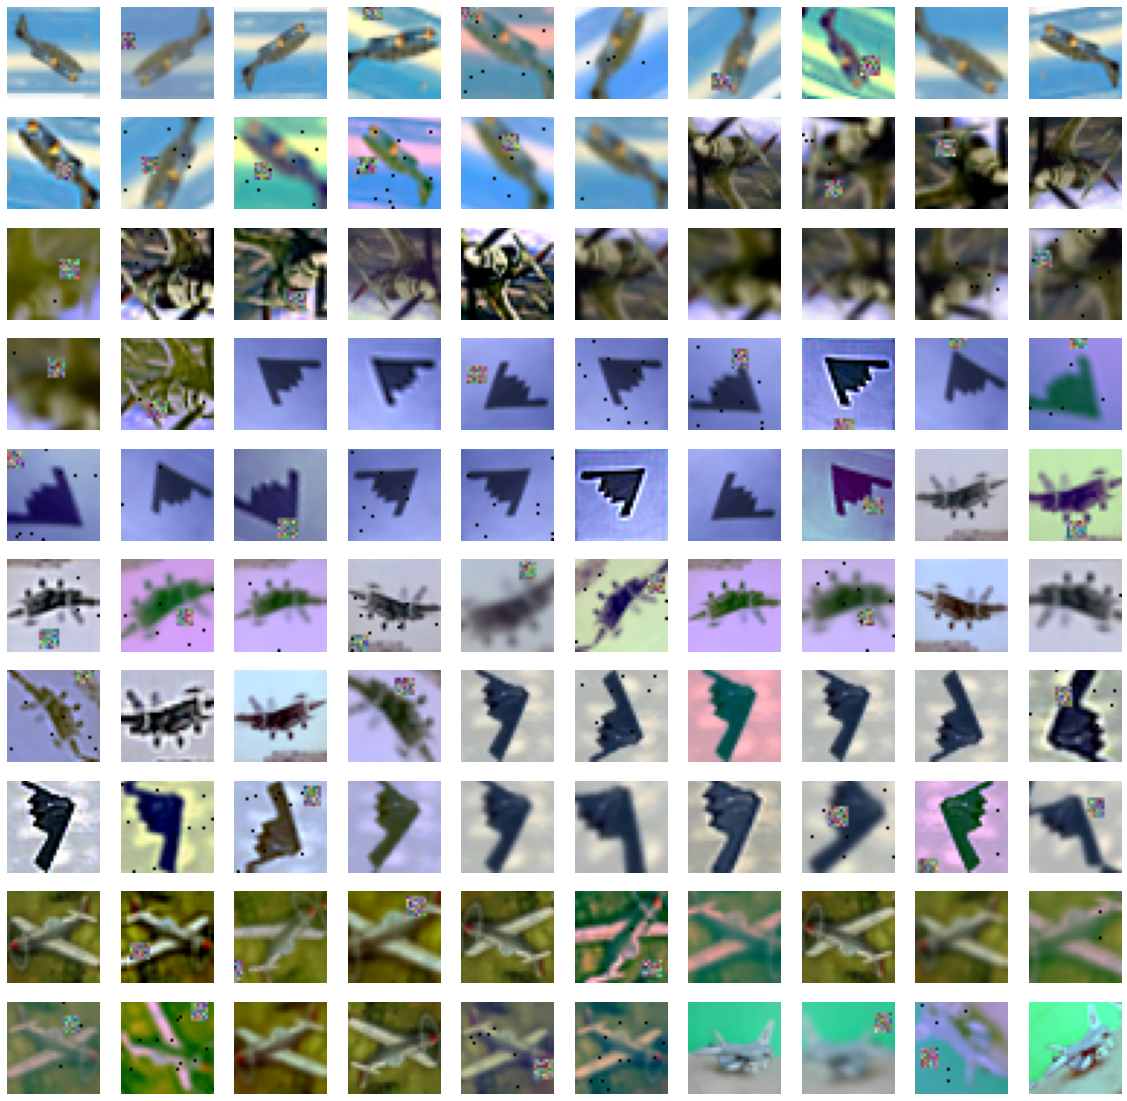

In [ ]:
plt.figure(figsize=(20,20))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.axis('off')
  plt.imshow(augmented_subsets[0][i].permute(1,2,0))